<a href="https://colab.research.google.com/github/wiv33/A-Learning-python/blob/master/machine-learning/_000_hello_machine/_002_examples/submit_or_not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls

drive  sample_data


In [3]:
import numpy as np

In [4]:
import pandas as pd

df_tag_map = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/programmers/tags.csv')

In [5]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/programmers/train.csv')

In [6]:
user_tag = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/programmers/user_tags.csv')

In [7]:
job_companies = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/programmers/job_companies.csv')

In [8]:
job_tag = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/programmers/job_tags.csv')

# 내부로 사용할 함수

In [9]:
def find_column_seq(df_data, target):
  for i, x in enumerate(df_data.columns):
    if target == x:
      return i, x

In [10]:
def update_col_in_df(update_df: pd.DataFrame, id: str, tags: []):
  for i in range(len(update_df[id])):
    if len(tags[update_df[id][i]]) > 0:
      for j in tags[update_df[id][i]]:
        j_idx = find_column_seq(update_df, j)[0]
        update_df.iloc[i: i+1, j_idx:j_idx + 1] += 1


# User Tag와 Job Tag Grouping


In [11]:
def grouping_tags(df: pd.DataFrame, id:str) -> {}:
  result = {}
  for u, t in df.groupby(id):
    result[u] = df[df[id] == u]['tagID'].values

  return result

# preprocessing Interface ( 데이터 전처리 ) 

In [12]:
def submit_preprocessing(data: pd.DataFrame, 
                         _tag_map: pd.DataFrame, 
                         _user_tag: pd.DataFrame,
                         _job_tag: pd.DataFrame,
                         _job_companies: pd.DataFrame) -> pd.DataFrame:
  tt = _tag_map.transpose()
  tt.columns = tt.values[0]
  df_merge = pd.merge(data, _job_companies[:][['jobID', 'companyID']])
  df_concat = pd.concat([df_merge, tt], ignore_index=True)
  df_concat.drop(df_concat.index[-2:, ], inplace=True)

  result =  df_concat.fillna(0)
  update_col_in_df(result, 'userID', grouping_tags(_user_tag.drop_duplicates(), 'userID'))
  # df_independent
  update_col_in_df(result, 'jobID', grouping_tags(_job_tag.drop_duplicates(), 'jobID'))
  return result.iloc[:, 3:]

# tagID 원-핫 인코딩 base df 초기화


*   모든 tag transpose
*   train data에 concat
*   companyID merge
*   nan to 0



In [13]:
독립 = train[:][['userID', 'jobID']]
df_train = submit_preprocessing(독립, 
                                _tag_map=df_tag_map,
                                _user_tag=user_tag,
                                _job_tag=job_tag,
                                _job_companies=job_companies)

In [14]:
df_y = train[['applied']]

In [15]:
print(df_train.shape)
print(df_y.shape)
# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)
# df_train = pca.fit_transform(df_train)
# print(df_train.shape)

(6000, 887)
(6000, 1)


# 모델 선언

In [45]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
tf.__version__

'2.3.0'

# 모델 훈련

In [42]:
train_data = df_train[:2000]
train_y = df_y[:2000]

test_data = df_train[2000:]
test_y = df_y[2000:]

In [43]:
test_data.shape, test_y.shape

((4000, 887), (4000, 1))

In [208]:
X = tf.keras.layers.Input(shape=[887])
H = tf.keras.layers.Flatten()(X)
H = tf.keras.layers.Dropout(rate=0.3)(H)

# H = tf.keras.layers.Dense(units=650)(H)
# H = tf.keras.layers.BatchNormalization()(H)
# H = tf.keras.layers.Activation(activation='swish')(H)

# H = tf.keras.layers.Dense(units=300)(H)
# H = tf.keras.layers.BatchNormalization()(H)
# H = tf.keras.layers.Activation(activation='swish')(H)

# H = tf.keras.layers.Dense(units=30)(H)
# H = tf.keras.layers.BatchNormalization()(H)
# H = tf.keras.layers.Activation(activation='swish')(H)

# H = tf.keras.layers.Dense(units=12)(H)
# H = tf.keras.layers.BatchNormalization()(H)
# H = tf.keras.layers.Activation(activation='swish')(H)

Y = tf.keras.layers.Dense(units=1, activation='sigmoid')(H)

model = tf.keras.Model(X, Y)

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=10, 
                                        restore_best_weights=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
print(df_train.shape, df_y.shape)

history = model.fit(train_data, 
                    train_y, 
                    batch_size=300, 
                    epochs=1000,
                    verbose=0,
                    validation_split=0.1,
                    validation_data=(test_data, test_y),
                    callbacks=early_stopping_callback)



Model: "functional_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 887)]             0         
_________________________________________________________________
flatten_59 (Flatten)         (None, 887)               0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 887)               0         
_________________________________________________________________
dense_324 (Dense)            (None, 1)                 888       
Total params: 888
Trainable params: 888
Non-trainable params: 0
_________________________________________________________________
(6000, 887) (6000, 1)


In [209]:
test_loss, test_acc = model.evaluate(test_data, test_y, batch_size=30, verbose=2)

134/134 - 0s - loss: 0.4341 - accuracy: 0.8565


In [85]:
test_y[test_y['applied'] == True]

,applied
2001,1
2010,1
2013,1
2017,1
2018,1
...,...
5976,1
5981,1
5983,1
5985,1


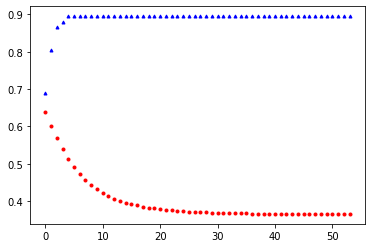

In [210]:
import matplotlib.pyplot as plt

y_vloss = history.history['val_loss']

# y_acc 에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['val_accuracy']

# x 값을 지정하고 정확도를 파란색으로, 오차를 빨간색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, 'o', c='red', markersize=3)
plt.plot(x_len, y_acc, '^', c='blue', markersize=3)

plt.show()

# 테스트 데이터 로딩

In [158]:
df_test_job = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/programmers/test_data/test_job.csv')

In [159]:
test_job = df_test_job.iloc[:, 0:2]
test_job.shape

(2435, 2)

In [160]:
test_predict = submit_preprocessing(df_test_job, 
                                _tag_map=df_tag_map,
                                _user_tag=user_tag,
                                _job_tag=job_tag,
                                _job_companies=job_companies)

KeyError: ignored

In [218]:
predictions = model.predict(test_predict)

array([[0.11912674],
       [0.13014908],
       [0.18704477],
       ...,
       [0.21621384],
       [0.33833304],
       [0.26585218]], dtype=float32)

In [217]:
predictions[predictions == 1]

array([], dtype=float32)